## Day 1 PINNs and PIKANS

## PINN for Burger's Equation in TensorFlow

In [1]:
import sys
sys.path.insert(0, 'Utilities/')
import os
from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io

In [4]:
np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)

#os.environ[‘TF_ENABLE_AUTO_MIXED_PRECISION’] = ‘1’

# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = X
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b 

def net_u(x, t, w, b):
    u = DNN(tf.concat([x,t],1), w, b)
    return u


#@tf.function(jit_compile=True)
@tf.function()
def net_f(x,t,W, b, nu):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([x, t])
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([x, t])
            u=net_u(x,t, W, b)
        u_t = tape2.gradient(u, t)
        u_x = tape2.gradient(u, x)
    u_xx = tape1.gradient(u_x, x)  
    f = u_t + u*u_x - nu*u_xx
    return f


#@tf.function()
@tf.function()
def train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, opt, nu):
    x_u = X_u_train_tf[:,0:1]
    t_u = X_u_train_tf[:,1:2]
    x_f = X_f_train_tf[:,0:1]
    t_f = X_f_train_tf[:,1:2]
    with tf.GradientTape() as tape:
        tape.watch([W,b])
        u_nn = net_u(x_u, t_u, W, b) 
        f_nn = net_f(x_f,t_f, W, b, nu)
        loss =  tf.reduce_mean(tf.square(u_nn - u_train_tf)) +\
        tf.reduce_mean(tf.square(f_nn)) 
    grads = tape.gradient(loss, train_vars(W, b))
    opt.apply_gradients(zip(grads, train_vars(W,b)))
    return loss





nu = 0.01/np.pi # Viscosity
N_u = 100 # Number of Initial and Boundary data points
N_f = 10000 # Number of residual point
Nmax=  1000

layers = [2] + [20]*8 + [1]

L = len(layers)
W = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)]


data = scipy.io.loadmat('./Data/burgers_shock.mat')
t = data['t'].flatten()[:,None]
x = data['x'].flatten()[:,None]
Exact = np.real(data['usol']).T
X, T = np.meshgrid(x,t)

X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
u_star = Exact.flatten()[:,None]

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)  

# Initial Condition
xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
uu1 = Exact[0:1,:].T

# Boundary condition -1
xx2 = np.hstack((X[:,0:1], T[:,0:1]))
uu2 = Exact[:,0:1]

# Boundary condition 1
xx3 = np.hstack((X[:,-1:], T[:,-1:]))
uu3 = Exact[:,-1:]

X_u_train = np.vstack([xx1, xx2, xx3])
X_f_train = lb + (ub-lb)*lhs(2, N_f)
X_f_train = np.vstack((X_f_train, X_u_train))
u_train = np.vstack([uu1, uu2, uu3])

idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)

X_u_train = X_u_train[idx, :]
u_train = u_train[idx,:]

X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
u_train_tf =   tf.convert_to_tensor(u_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)

lr = 1e-3
optimizer = tf.optimizers.Adam(learning_rate=lr)

start_time = time.time()
n=0
loss = []
while n <= Nmax:
    loss_ = train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, optimizer, nu)
    loss.append(loss_)
    if n % 100 == 0:
        print(f"Iteration is: {n} and loss is: {loss_}")
    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

    

Iteration is: 0 and loss is: 0.2566310465335846
Iteration is: 100 and loss is: 0.09962671250104904
Iteration is: 200 and loss is: 0.0860612541437149
Iteration is: 300 and loss is: 0.0775129646062851
Iteration is: 400 and loss is: 0.06608378142118454
Iteration is: 500 and loss is: 0.058337993919849396
Iteration is: 600 and loss is: 0.0481080636382103
Iteration is: 700 and loss is: 0.034001532942056656
Iteration is: 800 and loss is: 0.03114447183907032
Iteration is: 900 and loss is: 0.025854874402284622
Iteration is: 1000 and loss is: 0.020788315683603287
Training time: 47.2314


Error u: 5.037414e-01


/var/folders/fk/ct6y6fqd6kl_b95p4tls726c0000gq/T/ipykernel_32366/2942245171.py:21: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(gs0[:, :])


Text(0.5, 1.0, '$t = 0.75$')

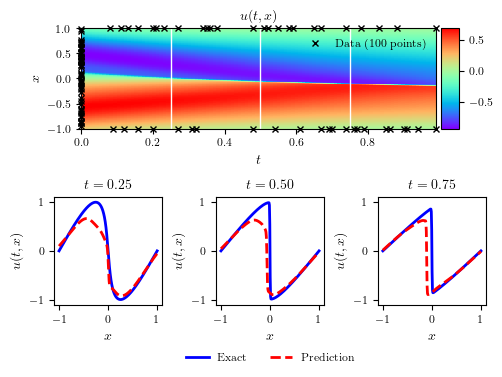

In [5]:
def predict(X_star_tf, w, b):
    x_star = X_star_tf[:,0:1]
    t_star = X_star_tf[:,1:2]
    u_pred = net_u(x_star, t_star, w, b)
    return u_pred
    
X_star_tf = tf.convert_to_tensor(X_star, dtype=tf.float32)    
u_pred = predict(X_star_tf, W, b)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' %(error_u))                     
U_pred = griddata(X_star, u_pred.numpy().flatten(), (X, T), method='cubic')
Error = 100* np.linalg.norm(Exact - U_pred) / np.linalg.norm(U_pred)


fig, ax = newfig(1.0, 1.1)
ax.axis('off')

####### Row 0: u(t,x) ##################    
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
              extent=[t.min(), t.max(), x.min(), x.max()], 
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)
#ax.plot(X_f_train[0:100,1], X_f_train[0:100,0], 'bx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)


line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('$u(t,x)$', fontsize = 10)

####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')    
ax.set_title('$t = 0.25$', fontsize = 10)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])    
ax.set_title('$t = 0.75$', fontsize = 10)

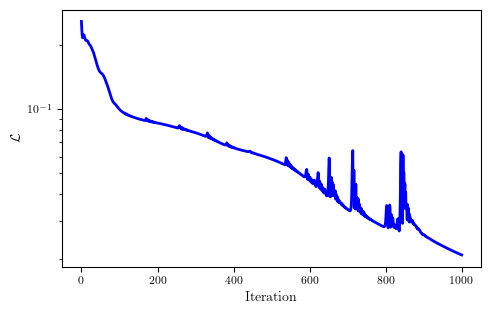

In [6]:
it = np.arange(0,Nmax, 1)
loss_list = [loss[i].numpy() for i in range(0,Nmax)]
plt.semilogy(it, np.asarray(loss_list), 'b-', linewidth = 2, label = 'Exact')       
plt.xlabel('Iteration')
plt.ylabel('$\mathcal{L}$')    
plt.show()

## PINN for Burger's Equation in JAX

In [7]:
import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random
import numpy as np
import scipy.io
from pyDOE import lhs
from jax.nn import tanh, relu
import sys
from jax.example_libraries import optimizers
from tqdm import trange
sys.path.insert(0, 'Utilities/')
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [ ]:
def random_layer_params(m, n, key, scale):
    w_key, b_key = random.split(key)
    return scale*random.normal(w_key, (m, n)), jnp.zeros(n)

def init_network_params(sizes, key):
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k, 2.0/(jnp.sqrt(m+n))) \
            for m, n, k in zip(sizes[:-1], sizes[1:], keys)]


@jit
def predict(params, X, lb, ub):
    H =  2.0*(X - lb)/(ub - lb) - 1.0
    for w, b in params[:-1]:
        H = tanh(jnp.dot(H, w) + b)
        final_w, final_b = params[-1]
    H = jnp.dot(H, final_w) + final_b
    return H


@jit
def net_u(params, x, t, lb, ub):
    x_con =jnp.array([x, t])
    y_pred = predict(params, x_con, lb, ub)
    return y_pred

@jit
def net_u_grad(params, x, t, lb, ub):
    x_con =jnp.array([x, t])
    y_pred = predict(params, x_con, lb, ub)
    return y_pred[0]

def net_f(params, lb, ub):
    def u_t(x, t):
        ut = grad(net_u_grad, argnums=2)(params, x, t, lb, ub) 
        return ut

    def u_x(x, t):
        ux = grad(net_u_grad, argnums=1)(params, x, t, lb, ub) 
        return ux   
    return jit(u_t), jit(u_x)


def net_fxx(params, lb, ub):
    def u_xx(x, t):
        _, u_x = net_f(params, lb, ub) 
        ux = grad(u_x, argnums=0)(x, t) 
        return ux   
    return jit(u_xx)


@jit
def loss_data(params,x,t, lb, ub, u_train):
    u_pred = vmap(net_u, (None, 0, 0, None, None))(params, x, t, lb, ub)
    loss = jnp.mean((u_pred - u_train)**2 )
    return loss

@jit
def loss_f(params, x, t, lb, ub, nu):
    u = vmap(net_u, (None, 0, 0, None, None))(params, x, t, lb, ub)
    u_tf, u_xf = net_f(params, lb, ub)
    u_xxf = net_fxx(params, lb, ub)
    u_t = vmap(u_tf, (0, 0))(x, t)
    u_x = vmap(u_xf, (0, 0))(x, t)
    u_xx = vmap(u_xxf, (0, 0))(x, t)
    res = u_t + u.flatten() * u_x - nu * u_xx 
    loss_f = jnp.mean((res.flatten())**2)
    return loss_f

@jit
def predict_u(params, x_star, t_star, lb, ub):
    u_pred = vmap(net_u, (None, 0, 0, None, None))\
    (params, x_star, t_star, lb, ub)
    return u_pred

def loss_fn(params, x_f, t_f,x_d, t_d, lb, ub, nu, y_d):
    loss_res = loss_f(params, x_f, t_f, lb, ub, nu)
    data_loss = loss_data(params, x_d, t_d, lb, ub, y_d) 
    return loss_res + data_loss

@jit
def step(istep, opt_state, t_d, x_d, y_d, t_f, x_f, lb, ub):
    param = get_params(opt_state) 
    g = grad(loss_fn, argnums=0)(param, x_f, t_f,x_d, t_d, lb, ub, nu, y_d)
    return opt_update(istep, g, opt_state)

if __name__ == "__main__":
    nu = 0.01/np.pi
    N_u = 100
    N_f = 10000
    layers = [2, 20, 20, 20, 20, 20, 20, 20,20, 20, 1]
    data = scipy.io.loadmat('Data/burgers_shock.mat')
    t = data['t'].flatten()[:,None]
    x = data['x'].flatten()[:,None]
    Exact = np.real(data['usol']).T    
    X, T = np.meshgrid(x,t)
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
    u_star = Exact.flatten()[:,None]              
    lb = X_star.min(0)
    ub = X_star.max(0)
    xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
    uu1 = Exact[0:1,:].T
    xx2 = np.hstack((X[:,0:1], T[:,0:1]))
    uu2 = Exact[:,0:1]
    xx3 = np.hstack((X[:,-1:], T[:,-1:]))
    uu3 = Exact[:,-1:]
    X_u_train = np.vstack([xx1, xx2, xx3])
    X_f_train = lb + (ub-lb)*lhs(2, N_f)
    X_f_train = np.vstack((X_f_train, X_u_train))
    u_train = np.vstack([uu1, uu2, uu3])
    idx = np.random.choice(X_u_train.shape[0], N_u, replace=False)
    X_u_train = X_u_train[idx, :]
    u_train = u_train[idx,:]
    x_d = X_u_train[:, 0]
    t_d = X_u_train[:, 1]
    x_f = X_f_train[:, 0]
    t_f = X_f_train[:, 1]
    x_star = X_star[:, 0]
    t_star = X_star[:, 1]
    params = init_network_params(layers, random.PRNGKey(1234))
    opt_init, opt_update, get_params = optimizers.adam(5e-4)
    opt_state = opt_init(params)
    nIter = 20000 + 1
    ld_list = []
    lf_list = []
    pbar = trange(nIter)
    
    for it in pbar:
        opt_state = step(it, opt_state, t_d, x_d, u_train, t_f, x_f, lb, ub)
        if it % 1 == 0:
            params = get_params(opt_state)
            l_d = loss_data(params, x_d, t_d, lb, ub, u_train)
            l_f = loss_f(params, x_f, t_f, lb, ub, nu)
            pbar.set_postfix({'Loss': l_d, 'loss_physics': l_f})
            ld_list.append(l_d)
            lf_list.append(l_f)


    u_pred = predict_u(params, x_star, t_star, lb, ub)
            
    error_u = jnp.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
    print('Error u: %e' % (error_u))
    np.save("ld_list.npy", np.array(ld_list), allow_pickle=True) 
    np.save("lf_list.npy", np.array(lf_list), allow_pickle=True)  
 
    
    U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
    Error = np.abs(Exact - U_pred)
    
    fig, ax = newfig(1.0, 1.1)
    ax.axis('off')
    
    ####### Row 0: u(t,x) ##################    
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])
    
    h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow', 
                  extent=[t.min(), t.max(), x.min(), x.max()], 
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_u_train[:,1], X_u_train[:,0], 'kx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)
    
    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)    
    
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$u(t,x)$', fontsize = 10)
    
    ####### Row 1: u(t,x) slices ##################    
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)
    
    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')    
    ax.set_title('$t = 0.25$', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    
    ax = plt.subplot(gs1[0, 1])
    ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.set_title('$t = 0.50$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)
    
    ax = plt.subplot(gs1[0, 2])
    ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$u(t,x)$')
    ax.axis('square')
    ax.set_xlim([-1.1,1.1])
    ax.set_ylim([-1.1,1.1])    
    ax.set_title('$t = 0.75$', fontsize = 10)

    savefig("Burgers")
    


## PINN for a Boundary Layer Problem

/var/folders/fk/ct6y6fqd6kl_b95p4tls726c0000gq/T/ipykernel_32366/1544187360.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-poster')


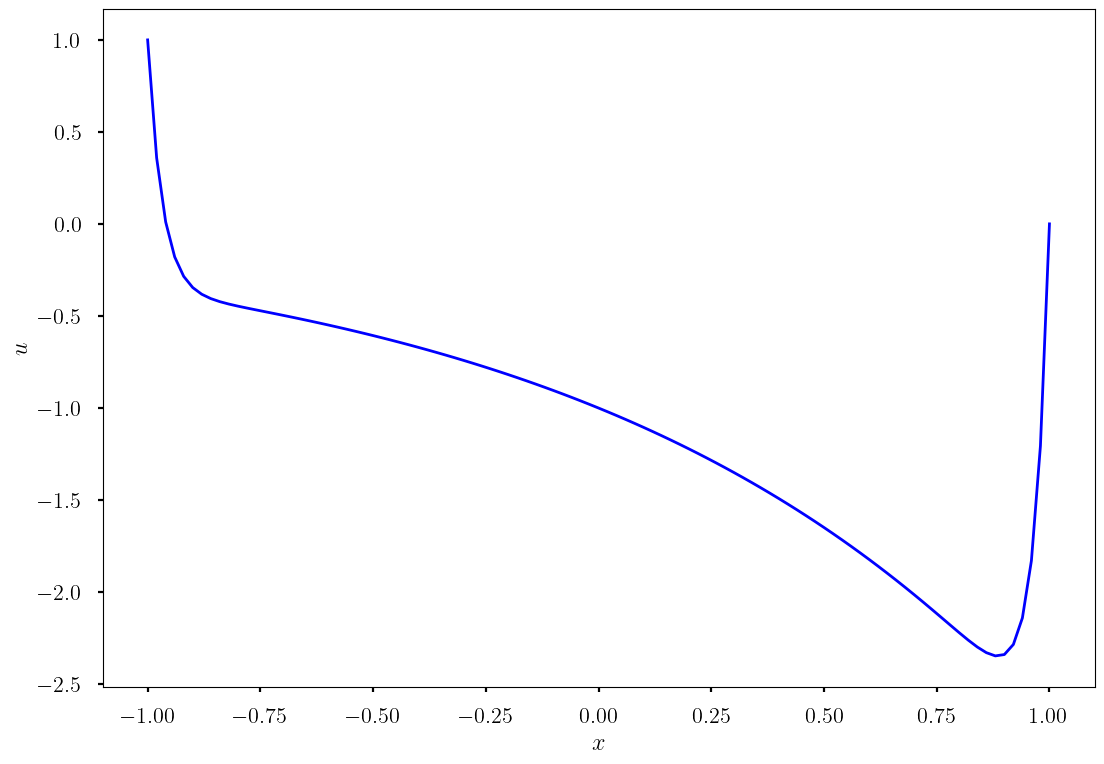

In [7]:
### Solution of Equation using Central Finite Difference Equation
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn-poster')
%matplotlib inline
matplotlib.rc('font', family='serif', serif='cm10')

matplotlib.rc('text', usetex=True)
### Number of Gridpoints
nu =1.0/10**-3
n = 100
h = (1+1) / n
x = np.linspace(-1,1,n+1)
# Difference Operator
A = np.zeros((n+1, n+1))

## Coefficient For Boundary Condition
A[0, 0] = 1
A[n, n] = 1

### Maric for Interior Point
for i in range(1, n):
    A[i, i-1] = 1
    A[i, i] = -(2 + (nu)*h**2)
    A[i, i+1] = 1

# Get b
b = np.zeros(n+1)
b = (np.exp(x))*h*h*(nu)

#### Imposition Boundary Condition 
b[0] = 1
b[-1] = 0
# solve the linear equations
y_act = np.linalg.solve(A, b)
### Plot of Equation
gs = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs[0, 0])
ax.plot(x, y_act, "-", lw=2.0, color="b")
ax.set_xlabel('$x$')
ax.set_ylabel("$u$")
plt.show()


In [8]:
#Using Vanilla PINN

import sys
sys.path.insert(0, 'Utilities/')
import os

from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io

np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
lb = -1
ub = 1   

# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = 2.0*(X - lb)/(ub - lb) - 1.0
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars(W, b):
    return W + b

def net_u(x,w, b):
    u = DNN(x, w, b)
    return u


#@tf.function(jit_compile=True)
@tf.function
def net_f(x,W, b, nu):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([x])
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([x])
            u=net_u(x, W, b)
        u_x = tape2.gradient(u, x)
        del tape2
    u_xx = tape1.gradient(u_x, x)  
    del tape1
    f = u_xx - (1/nu)*u-(1/nu)*tf.exp(x)
    return f



#@tf.function(jit_compile=True)
@tf.function
def train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, opt, nu):
    x_u = X_u_train_tf
    x_f = X_f_train_tf
    with tf.GradientTape() as tape:
        tape.watch([W,b])
        u_nn = net_u(x_u, W, b) 
        f_nn = net_f(x_f,W, b, nu)
        loss =  100.0*tf.reduce_mean(tf.square(u_nn - u_train_tf)) + tf.reduce_mean(tf.square(f_nn)) 
    grads = tape.gradient(loss, train_vars(W,b))
    opt.apply_gradients(zip(grads, train_vars(W,b)))
    return loss

def predict(X_star_tf, w, b):
    u_pred = net_u(X_star_tf, w, b)
    return u_pred
    
nu = 10**3
noise = 0.0        
N_f = 300
Nmax=3000

layers = [1, 4,4,4,4,4,4, 1]
L = len(layers)
W = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)] 

x_0 = -1
x_1 = 1
u_0 = 1
u_1 = 0

X_u_train = np.vstack([x_0, x_1])
u_train = np.vstack([u_0, u_1])

X_f_train = lb + (ub-lb)*lhs(1, N_f)
X_f_star =  np.linspace(-1,1,200)
X_f_star = X_f_star.reshape((-1,1))


X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
u_train_tf =   tf.convert_to_tensor(u_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)
X_star_tf = tf.convert_to_tensor(X_f_star, dtype=tf.float32)


lr = 5e-3
optimizer = tf.optimizers.Adam(learning_rate=lr)

start_time = time.time()
n=0
loss = []
while n <= Nmax:
    loss_= train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, optimizer, nu)
    loss.append(loss_) 
    if n%100==0:
        print(f"Iteration is: {n} and loss is: {loss_}")
    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))

Iteration is: 0 and loss is: 36.536865234375
Iteration is: 100 and loss is: 0.2546336352825165
Iteration is: 200 and loss is: 0.06440890580415726
Iteration is: 300 and loss is: 0.016142578795552254
Iteration is: 400 and loss is: 0.009148630313575268
Iteration is: 500 and loss is: 0.00654613645747304
Iteration is: 600 and loss is: 0.004988257307559252
Iteration is: 700 and loss is: 0.003951159305870533
Iteration is: 800 and loss is: 0.003213557181879878
Iteration is: 900 and loss is: 0.0026650174986571074
Iteration is: 1000 and loss is: 0.0022440773900598288
Iteration is: 1100 and loss is: 0.0030622859485447407
Iteration is: 1200 and loss is: 0.0016601447714492679
Iteration is: 1300 and loss is: 0.00146115489769727
Iteration is: 1400 and loss is: 0.0013157266657799482
Iteration is: 1500 and loss is: 0.0011574935633689165
Iteration is: 1600 and loss is: 0.0010577195789664984
Iteration is: 1700 and loss is: 0.0023304757196456194
Iteration is: 1800 and loss is: 0.0008813373278826475
Iterat

Iteration is: 267 and loss is: 0.023541711270809174
Iteration is: 268 and loss is: 0.023230718448758125
Iteration is: 269 and loss is: 0.02292618155479431
Iteration is: 270 and loss is: 0.022628026083111763
Iteration is: 271 and loss is: 0.02233613096177578
Iteration is: 272 and loss is: 0.0220504067838192
Iteration is: 273 and loss is: 0.021770725026726723
Iteration is: 274 and loss is: 0.02149706333875656
Iteration is: 275 and loss is: 0.021229257807135582
Iteration is: 276 and loss is: 0.020967189222574234
Iteration is: 277 and loss is: 0.020710786804556847
Iteration is: 278 and loss is: 0.020459875464439392
Iteration is: 279 and loss is: 0.020214436575770378
Iteration is: 280 and loss is: 0.019974373281002045
Iteration is: 281 and loss is: 0.01973952353000641
Iteration is: 282 and loss is: 0.019509822130203247
Iteration is: 283 and loss is: 0.019285136833786964
Iteration is: 284 and loss is: 0.01906542293727398
Iteration is: 285 and loss is: 0.018850479274988174
Iteration is: 286 a

Iteration is: 575 and loss is: 0.0053161620162427425
Iteration is: 576 and loss is: 0.005302376113831997
Iteration is: 577 and loss is: 0.005288665648549795
Iteration is: 578 and loss is: 0.005274992436170578
Iteration is: 579 and loss is: 0.005261383019387722
Iteration is: 580 and loss is: 0.005247836466878653
Iteration is: 581 and loss is: 0.0052343509159982204
Iteration is: 582 and loss is: 0.005220902152359486
Iteration is: 583 and loss is: 0.005207516718655825
Iteration is: 584 and loss is: 0.005194187629967928
Iteration is: 585 and loss is: 0.00518092792481184
Iteration is: 586 and loss is: 0.005167705938220024
Iteration is: 587 and loss is: 0.005154550075531006
Iteration is: 588 and loss is: 0.005141441244632006
Iteration is: 589 and loss is: 0.005128383170813322
Iteration is: 590 and loss is: 0.00511538190767169
Iteration is: 591 and loss is: 0.005102433264255524
Iteration is: 592 and loss is: 0.005089542828500271
Iteration is: 593 and loss is: 0.005076698027551174
Iteration is

Iteration is: 880 and loss is: 0.0027629949618130922
Iteration is: 881 and loss is: 0.0027579672168940306
Iteration is: 882 and loss is: 0.0027529567014425993
Iteration is: 883 and loss is: 0.002747961552813649
Iteration is: 884 and loss is: 0.0027429794427007437
Iteration is: 885 and loss is: 0.0027380045503377914
Iteration is: 886 and loss is: 0.002733048750087619
Iteration is: 887 and loss is: 0.002728106686845422
Iteration is: 888 and loss is: 0.002723176032304764
Iteration is: 889 and loss is: 0.002718257484957576
Iteration is: 890 and loss is: 0.0027133533731102943
Iteration is: 891 and loss is: 0.0027084597386419773
Iteration is: 892 and loss is: 0.002703581005334854
Iteration is: 893 and loss is: 0.002698714379221201
Iteration is: 894 and loss is: 0.002693864284083247
Iteration is: 895 and loss is: 0.0026890221051871777
Iteration is: 896 and loss is: 0.002684197388589382
Iteration is: 897 and loss is: 0.002679381985217333
Iteration is: 898 and loss is: 0.0026745835784822702
Ite

Iteration is: 1186 and loss is: 0.00169350893702358
Iteration is: 1187 and loss is: 0.0016911911079660058
Iteration is: 1188 and loss is: 0.0016888539539650083
Iteration is: 1189 and loss is: 0.0016865013167262077
Iteration is: 1190 and loss is: 0.0016841215547174215
Iteration is: 1191 and loss is: 0.0016817235155031085
Iteration is: 1192 and loss is: 0.0016793119721114635
Iteration is: 1193 and loss is: 0.0016768969362601638
Iteration is: 1194 and loss is: 0.00167447654530406
Iteration is: 1195 and loss is: 0.0016720659332349896
Iteration is: 1196 and loss is: 0.0016696592792868614
Iteration is: 1197 and loss is: 0.0016672598430886865
Iteration is: 1198 and loss is: 0.0016648727469146252
Iteration is: 1199 and loss is: 0.0016625006683170795
Iteration is: 1200 and loss is: 0.0016601447714492679
Iteration is: 1201 and loss is: 0.0016578056383877993
Iteration is: 1202 and loss is: 0.0016554819885641336
Iteration is: 1203 and loss is: 0.0016531851142644882
Iteration is: 1204 and loss is: 

Iteration is: 1339 and loss is: 0.0013891536509618163
Iteration is: 1340 and loss is: 0.0013873910065740347
Iteration is: 1341 and loss is: 0.0013856269652023911
Iteration is: 1342 and loss is: 0.001383871422149241
Iteration is: 1343 and loss is: 0.0013821210013702512
Iteration is: 1344 and loss is: 0.001380381640046835
Iteration is: 1345 and loss is: 0.0013786540366709232
Iteration is: 1346 and loss is: 0.001376934815198183
Iteration is: 1347 and loss is: 0.0013752342201769352
Iteration is: 1348 and loss is: 0.0013735551619902253
Iteration is: 1349 and loss is: 0.0013719090493395925
Iteration is: 1350 and loss is: 0.0013703088043257594
Iteration is: 1351 and loss is: 0.0013687730534002185
Iteration is: 1352 and loss is: 0.0013673335779458284
Iteration is: 1353 and loss is: 0.001366029609926045
Iteration is: 1354 and loss is: 0.0013649334432557225
Iteration is: 1355 and loss is: 0.001364135299809277
Iteration is: 1356 and loss is: 0.0013637918746098876
Iteration is: 1357 and loss is: 0

Iteration is: 1492 and loss is: 0.001167993643321097
Iteration is: 1493 and loss is: 0.001166653586551547
Iteration is: 1494 and loss is: 0.0011653214460238814
Iteration is: 1495 and loss is: 0.0011639922158792615
Iteration is: 1496 and loss is: 0.0011626728810369968
Iteration is: 1497 and loss is: 0.00116136169526726
Iteration is: 1498 and loss is: 0.0011600570287555456
Iteration is: 1499 and loss is: 0.0011587690096348524
Iteration is: 1500 and loss is: 0.0011574935633689165
Iteration is: 1501 and loss is: 0.0011562437284737825
Iteration is: 1502 and loss is: 0.0011550355702638626
Iteration is: 1503 and loss is: 0.0011538820108398795
Iteration is: 1504 and loss is: 0.0011528077302500606
Iteration is: 1505 and loss is: 0.0011518483515828848
Iteration is: 1506 and loss is: 0.0011510620824992657
Iteration is: 1507 and loss is: 0.0011505300644785166
Iteration is: 1508 and loss is: 0.0011503802379593253
Iteration is: 1509 and loss is: 0.0011508235475048423
Iteration is: 1510 and loss is: 

Iteration is: 1797 and loss is: 0.0008837631321512163
Iteration is: 1798 and loss is: 0.0008829417056404054
Iteration is: 1799 and loss is: 0.0008821497322060168
Iteration is: 1800 and loss is: 0.0008813373278826475
Iteration is: 1801 and loss is: 0.0008804774261079729
Iteration is: 1802 and loss is: 0.0008795679896138608
Iteration is: 1803 and loss is: 0.000878628809005022
Iteration is: 1804 and loss is: 0.0008776907343417406
Iteration is: 1805 and loss is: 0.0008767752442508936
Iteration is: 1806 and loss is: 0.0008758946205489337
Iteration is: 1807 and loss is: 0.0008750395500101149
Iteration is: 1808 and loss is: 0.0008742056088522077
Iteration is: 1809 and loss is: 0.0008733715512789786
Iteration is: 1810 and loss is: 0.0008725245133973658
Iteration is: 1811 and loss is: 0.0008716612937860191
Iteration is: 1812 and loss is: 0.0008707877714186907
Iteration is: 1813 and loss is: 0.0008699037716723979
Iteration is: 1814 and loss is: 0.0008690195390954614
Iteration is: 1815 and loss i

Iteration is: 2097 and loss is: 0.0007010091794654727
Iteration is: 2098 and loss is: 0.000700561620760709
Iteration is: 2099 and loss is: 0.0007002291968092322
Iteration is: 2100 and loss is: 0.0007000832119956613
Iteration is: 2101 and loss is: 0.000700257602147758
Iteration is: 2102 and loss is: 0.000700978736858815
Iteration is: 2103 and loss is: 0.0007026436505839229
Iteration is: 2104 and loss is: 0.0007059507188387215
Iteration is: 2105 and loss is: 0.0007121142698451877
Iteration is: 2106 and loss is: 0.0007233586511574686
Iteration is: 2107 and loss is: 0.0007436576997861266
Iteration is: 2108 and loss is: 0.0007803455810062587
Iteration is: 2109 and loss is: 0.0008465510909445584
Iteration is: 2110 and loss is: 0.0009672074811533093
Iteration is: 2111 and loss is: 0.0011864296393468976
Iteration is: 2112 and loss is: 0.001589555642567575
Iteration is: 2113 and loss is: 0.0023210435174405575
Iteration is: 2114 and loss is: 0.0036599463783204556
Iteration is: 2115 and loss is: 

Iteration is: 2398 and loss is: 0.002198541071265936
Iteration is: 2399 and loss is: 0.003224175190553069
Iteration is: 2400 and loss is: 0.001827344880439341
Iteration is: 2401 and loss is: 0.0006366020534187555
Iteration is: 2402 and loss is: 0.0014394355239346623
Iteration is: 2403 and loss is: 0.002306163776665926
Iteration is: 2404 and loss is: 0.0015920395962893963
Iteration is: 2405 and loss is: 0.0006663230597041547
Iteration is: 2406 and loss is: 0.0010272609069943428
Iteration is: 2407 and loss is: 0.001700817490927875
Iteration is: 2408 and loss is: 0.0013702856376767159
Iteration is: 2409 and loss is: 0.0006981492624618113
Iteration is: 2410 and loss is: 0.0008059613755904138
Iteration is: 2411 and loss is: 0.001286603044718504
Iteration is: 2412 and loss is: 0.001188386231660843
Iteration is: 2413 and loss is: 0.0007236158126033843
Iteration is: 2414 and loss is: 0.0006927952053956687
Iteration is: 2415 and loss is: 0.0010160470847040415
Iteration is: 2416 and loss is: 0.0

Iteration is: 2698 and loss is: 0.0009640892967581749
Iteration is: 2699 and loss is: 0.000844761379994452
Iteration is: 2700 and loss is: 0.0005958487163297832
Iteration is: 2701 and loss is: 0.000603521941229701
Iteration is: 2702 and loss is: 0.0007805919158272445
Iteration is: 2703 and loss is: 0.0007947940612211823
Iteration is: 2704 and loss is: 0.0006327134324237704
Iteration is: 2705 and loss is: 0.0005600990261882544
Iteration is: 2706 and loss is: 0.0006545911310240626
Iteration is: 2707 and loss is: 0.0007230807677842677
Iteration is: 2708 and loss is: 0.000651409151032567
Iteration is: 2709 and loss is: 0.0005622819880954921
Iteration is: 2710 and loss is: 0.0005828362773172557
Iteration is: 2711 and loss is: 0.0006505681085400283
Iteration is: 2712 and loss is: 0.0006447418127208948
Iteration is: 2713 and loss is: 0.0005794416647404432
Iteration is: 2714 and loss is: 0.0005554444505833089
Iteration is: 2715 and loss is: 0.0005935142980888486
Iteration is: 2716 and loss is:

Error u: 1.930983e+01


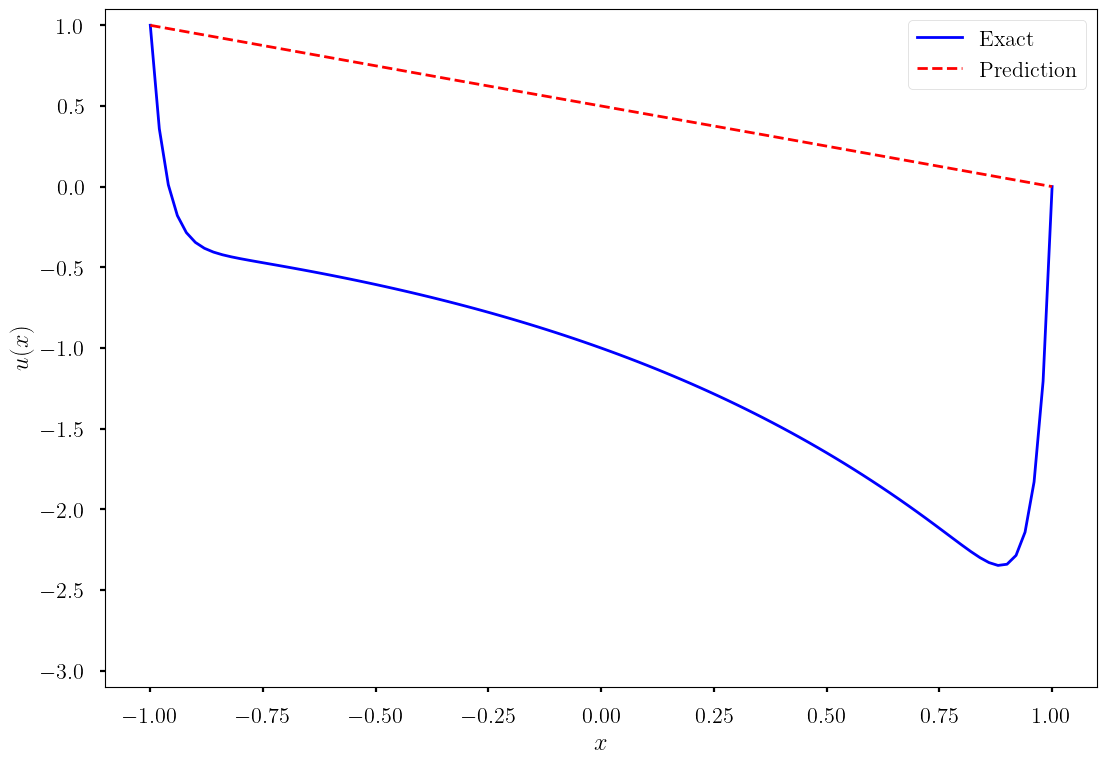

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


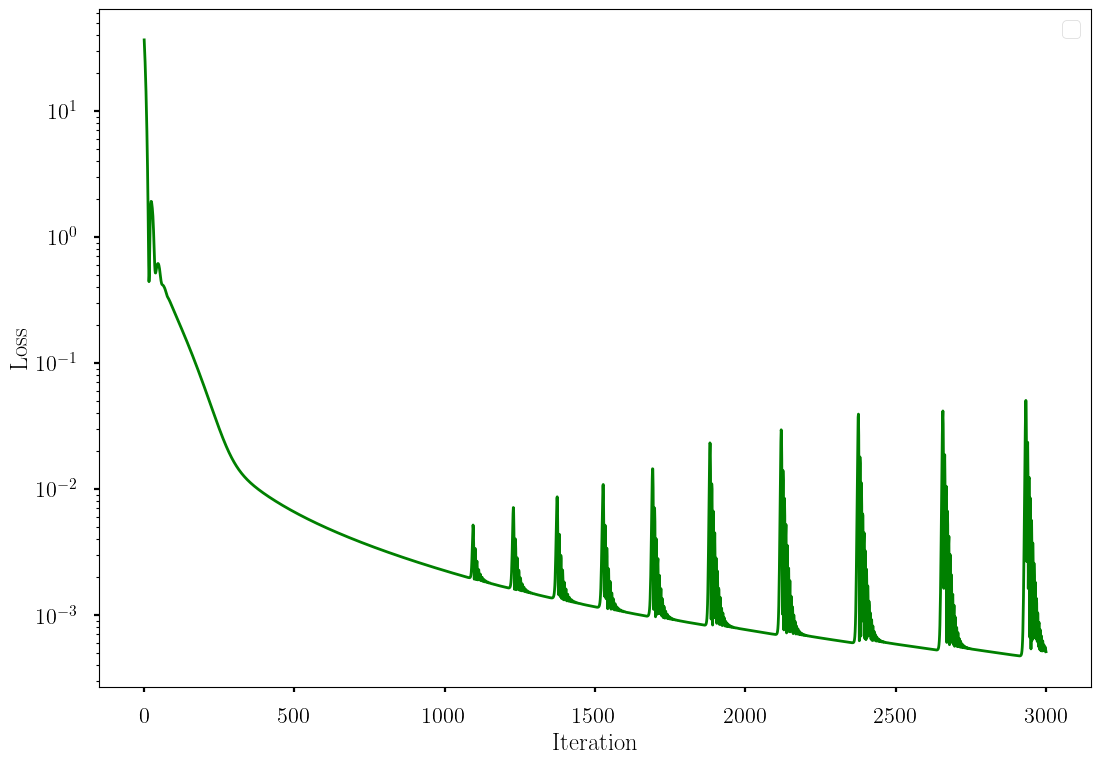

In [9]:
def predict(X_star_tf, w, b):
    x_star = X_star_tf
    u_pred = net_u(x_star, w, b)
    return u_pred

u_star = y_act
    
u_pred = predict(X_star_tf, W, b)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' % (error_u))                     



####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 1)
#gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,y_act, 'b-', linewidth = 2, label = 'Exact')       
ax.plot(X_f_star, u_pred, '--r', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(x)$') 
plt.legend()
#ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-3.1,1.1])
plt.show()

###############################################
loss_list = [loss[i].numpy() for i in range(len(loss))]


gs2 = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs2[0, 0])

ep = np.arange(0,Nmax+1,1)
ax.semilogy(ep,loss_list, 'g-', linewidth = 2)       
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss') 
plt.legend()
#ax.axis('square')
##ax.set_xlim([-1.1,1.1])
##x.set_ylim([-3.1,1.1])
plt.show()





## Self Adaptive weighting for residual minimzation

In [10]:
##Self Adaptive weighting for residual minimzation
import sys
sys.path.insert(0, 'Utilities/')
import os
from scipy.interpolate import griddata
from pyDOE import lhs
from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.io

np.random.seed(seed=1234)
tf.random.set_seed(1234)
tf.config.experimental.enable_tensor_float_32_execution(False)
lb = -1
ub = 1   

# Initalization of Network
def hyper_initial(size):
    in_dim = size[0]
    out_dim = size[1]
    std = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.random.truncated_normal(shape=size, stddev = std))

# Neural Network 
def DNN(X, W, b):
    A = 2.0*(X - lb)/(ub - lb) - 1.0
    L = len(W)
    for i in range(L-1):
        A = tf.tanh(tf.add(tf.matmul(A, W[i]), b[i]))
    Y = tf.add(tf.matmul(A, W[-1]), b[-1])
    return Y

def train_vars_nn(W, b):
    return W + b

def train_vars_total(W, b, lambda_r, lambda_b):
    return W + b + lambda_r + lambda_b

def train_vars_sa(lambda_r, lambda_b):
    return lambda_r + lambda_b

def net_u(x,w, b):
    u = DNN(x, w, b)
    return u

def loss_weight(N_r, N_b):
    alpha_b = tf.Variable(tf.reshape(tf.repeat(1000.0, N_b), (N_b, -1))) 
    alpha_r = tf.Variable(tf.ones(shape=[N_r, 1]), dtype=tf.float32)
    return alpha_r, alpha_b


#@tf.function(jit_compile=True)
@tf.function
def net_f(x, W, b, nu):
    with tf.GradientTape(persistent=True) as tape1:
        tape1.watch([x])
        with tf.GradientTape(persistent=True) as tape2:
            tape2.watch([x])
            u=net_u(x, W, b)
        u_x = tape2.gradient(u, x)
        del tape2
    u_xx = tape1.gradient(u_x, x)  
    del tape1
    f = u_xx - (1/nu)*u - (1/nu)*tf.exp(x)
    return f

# @tf.function
# def net_fd(x, W, b, nu):
#     h=0.1
#     u_xx= (1/(h**2))*(net_u(x + h , W, b) - net_u(x, W, b) + net_u(x-h, W, b))
#     f = u_xx - (1/nu)*u-(1/nu)*tf.exp(x)
#     return f



#@tf.function(jit_compile=True)
@tf.function()
def train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, opt, nu, lambda_r, lambda_b):
    x_u = X_u_train_tf
    x_f = X_f_train_tf
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([W,b,lambda_r,lambda_b])
        u_nn = net_u(x_u, W, b) 
        f_nn = net_f(x_f,W, b, nu)
        loss_r = tf.square(lambda_r*f_nn)
        loss_b = tf.square(lambda_b*(u_nn-u_train_tf))
        loss =    tf.reduce_mean(loss_b) + tf.reduce_mean(loss_r)  
    grads = tape.gradient(loss, train_vars_nn(W, b))
    grads_u = tape.gradient(loss, lambda_r)
    grads_b = tape.gradient(loss, lambda_b)
    opt.apply_gradients(zip(grads, train_vars_nn(W,b)))
    opt.apply_gradients(zip([-grads_u], [lambda_r]))
    opt.apply_gradients(zip([-grads_b], [lambda_b]))
    return loss

def predict(X_star_tf, w, b):
    u_pred = net_u(X_star_tf, w, b)
    return u_pred
    
nu = 10**-3
Nmax= 5000
N_f = 500
N_b = 2

layers = [1,8,8,8,8,8,8,1]
L = len(layers)
W = [hyper_initial([layers[l-1], layers[l]]) for l in range(1, L)] 
b = [tf.Variable(tf.zeros([1, layers[l]])) for l in range(1, L)] 

alpha_r, alpha_b = loss_weight(N_f, N_b)

x_0 = -1
x_1 = 1
u_0 = 1
u_1 = 0

X_u_train = np.vstack([x_0, x_1])
u_train = np.vstack([u_0, u_1])

X_f_train = lb + (ub-lb)*lhs(1, N_f)
X_f_star =  np.linspace(-1,1,101)
X_f_star = X_f_star.reshape((-1,1))


X_u_train_tf = tf.convert_to_tensor(X_u_train, dtype=tf.float32)
u_train_tf =   tf.convert_to_tensor(u_train, dtype=tf.float32)
X_f_train_tf = tf.convert_to_tensor(X_f_train, dtype=tf.float32)
X_star_tf = tf.convert_to_tensor(X_f_star, dtype=tf.float32)


lr = 1e-3
optimizer = tf.keras.optimizers.legacy.Adam()

start_time = time.time()
n=0
loss = []
while n <= Nmax:
    loss_= train_step(W, b, X_u_train_tf, u_train_tf, X_f_train_tf, 
                      optimizer, nu, alpha_r, alpha_b)
    loss.append(loss_)
    if n%100==0:
        print(f"Iteration is: {n} and loss is: {loss_}")
    n+=1

elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))


Iteration is: 0 and loss is: 2177501.0
Iteration is: 100 and loss is: 1149230.125
Iteration is: 200 and loss is: 1202667.75
Iteration is: 300 and loss is: 1266019.75
Iteration is: 400 and loss is: 1335037.0
Iteration is: 500 and loss is: 1405194.125
Iteration is: 600 and loss is: 1235598.0
Iteration is: 700 and loss is: 512831.5
Iteration is: 800 and loss is: 241546.640625
Iteration is: 900 and loss is: 83705.5859375
Iteration is: 1000 and loss is: 29546.0546875
Iteration is: 1100 and loss is: 13007.6123046875
Iteration is: 1200 and loss is: 8846.859375
Iteration is: 1300 and loss is: 6365.81201171875
Iteration is: 1400 and loss is: 4709.201171875
Iteration is: 1500 and loss is: 3619.9091796875
Iteration is: 1600 and loss is: 2958.91162109375
Iteration is: 1700 and loss is: 2452.6572265625
Iteration is: 1800 and loss is: 2448.462890625
Iteration is: 1900 and loss is: 1877.49853515625
Iteration is: 2000 and loss is: 2622.6064453125
Iteration is: 2100 and loss is: 2740.08447265625
Iterat

Iteration is: 246 and loss is: 1235604.0
Iteration is: 247 and loss is: 1235662.5
Iteration is: 248 and loss is: 1236820.125
Iteration is: 249 and loss is: 1237199.75
Iteration is: 250 and loss is: 1237629.5
Iteration is: 251 and loss is: 1238646.0
Iteration is: 252 and loss is: 1238866.75
Iteration is: 253 and loss is: 1239615.5
Iteration is: 254 and loss is: 1240345.125
Iteration is: 255 and loss is: 1240656.875
Iteration is: 256 and loss is: 1241505.25
Iteration is: 257 and loss is: 1242033.0
Iteration is: 258 and loss is: 1242496.75
Iteration is: 259 and loss is: 1243297.75
Iteration is: 260 and loss is: 1243761.625
Iteration is: 261 and loss is: 1244306.25
Iteration is: 262 and loss is: 1245041.25
Iteration is: 263 and loss is: 1245513.625
Iteration is: 264 and loss is: 1246062.375
Iteration is: 265 and loss is: 1246757.375
Iteration is: 266 and loss is: 1247267.75
Iteration is: 267 and loss is: 1247779.0
Iteration is: 268 and loss is: 1248433.875
Iteration is: 269 and loss is: 12

Iteration is: 486 and loss is: 1398525.5
Iteration is: 487 and loss is: 1398837.0
Iteration is: 488 and loss is: 1399400.25
Iteration is: 489 and loss is: 1400138.5
Iteration is: 490 and loss is: 1400825.125
Iteration is: 491 and loss is: 1401392.5
Iteration is: 492 and loss is: 1401732.75
Iteration is: 493 and loss is: 1402066.0
Iteration is: 494 and loss is: 1402478.875
Iteration is: 495 and loss is: 1403009.0
Iteration is: 496 and loss is: 1403587.5
Iteration is: 497 and loss is: 1404097.375
Iteration is: 498 and loss is: 1404527.75
Iteration is: 499 and loss is: 1404860.625
Iteration is: 500 and loss is: 1405194.125
Iteration is: 501 and loss is: 1405565.75
Iteration is: 502 and loss is: 1405981.5
Iteration is: 503 and loss is: 1406406.5
Iteration is: 504 and loss is: 1406790.625
Iteration is: 505 and loss is: 1407126.75
Iteration is: 506 and loss is: 1407406.375
Iteration is: 507 and loss is: 1407669.375
Iteration is: 508 and loss is: 1407933.125
Iteration is: 509 and loss is: 140

Iteration is: 723 and loss is: 431797.78125
Iteration is: 724 and loss is: 429698.875
Iteration is: 725 and loss is: 426367.75
Iteration is: 726 and loss is: 421263.4375
Iteration is: 727 and loss is: 415663.4375
Iteration is: 728 and loss is: 411724.875
Iteration is: 729 and loss is: 410095.125
Iteration is: 730 and loss is: 409349.125
Iteration is: 731 and loss is: 407619.65625
Iteration is: 732 and loss is: 404460.46875
Iteration is: 733 and loss is: 400124.8125
Iteration is: 734 and loss is: 395723.65625
Iteration is: 735 and loss is: 391715.96875
Iteration is: 736 and loss is: 388654.5625
Iteration is: 737 and loss is: 386637.0625
Iteration is: 738 and loss is: 385296.4375
Iteration is: 739 and loss is: 384194.09375
Iteration is: 740 and loss is: 382744.75
Iteration is: 741 and loss is: 381151.5625
Iteration is: 742 and loss is: 378460.125
Iteration is: 743 and loss is: 374584.8125
Iteration is: 744 and loss is: 369397.25
Iteration is: 745 and loss is: 364620.125
Iteration is: 746

Iteration is: 962 and loss is: 31306.458984375
Iteration is: 963 and loss is: 30945.986328125
Iteration is: 964 and loss is: 30843.275390625
Iteration is: 965 and loss is: 30881.357421875
Iteration is: 966 and loss is: 31059.97265625
Iteration is: 967 and loss is: 31127.330078125
Iteration is: 968 and loss is: 31360.109375
Iteration is: 969 and loss is: 31232.728515625
Iteration is: 970 and loss is: 31373.16796875
Iteration is: 971 and loss is: 30975.142578125
Iteration is: 972 and loss is: 30919.091796875
Iteration is: 973 and loss is: 30273.87109375
Iteration is: 974 and loss is: 29956.404296875
Iteration is: 975 and loss is: 29165.61328125
Iteration is: 976 and loss is: 28635.240234375
Iteration is: 977 and loss is: 27864.697265625
Iteration is: 978 and loss is: 27283.322265625
Iteration is: 979 and loss is: 26669.115234375
Iteration is: 980 and loss is: 26184.109375
Iteration is: 981 and loss is: 25757.798828125
Iteration is: 982 and loss is: 25413.7890625
Iteration is: 983 and los

Iteration is: 1202 and loss is: 8785.5400390625
Iteration is: 1203 and loss is: 8755.001953125
Iteration is: 1204 and loss is: 8724.6552734375
Iteration is: 1205 and loss is: 8693.8505859375
Iteration is: 1206 and loss is: 8662.7607421875
Iteration is: 1207 and loss is: 8631.751953125
Iteration is: 1208 and loss is: 8601.271484375
Iteration is: 1209 and loss is: 8570.10546875
Iteration is: 1210 and loss is: 8539.9228515625
Iteration is: 1211 and loss is: 8509.318359375
Iteration is: 1212 and loss is: 8479.3046875
Iteration is: 1213 and loss is: 8449.14453125
Iteration is: 1214 and loss is: 8419.384765625
Iteration is: 1215 and loss is: 8389.6591796875
Iteration is: 1216 and loss is: 8360.37890625
Iteration is: 1217 and loss is: 8330.9814453125
Iteration is: 1218 and loss is: 8302.0400390625
Iteration is: 1219 and loss is: 8273.232421875
Iteration is: 1220 and loss is: 8244.3896484375
Iteration is: 1221 and loss is: 8216.11328125
Iteration is: 1222 and loss is: 8187.83251953125
Iteratio

Iteration is: 1443 and loss is: 8524.9287109375
Iteration is: 1444 and loss is: 8378.6787109375
Iteration is: 1445 and loss is: 9011.869140625
Iteration is: 1446 and loss is: 8083.35302734375
Iteration is: 1447 and loss is: 7769.0673828125
Iteration is: 1448 and loss is: 6424.84765625
Iteration is: 1449 and loss is: 5541.3154296875
Iteration is: 1450 and loss is: 4655.11474609375
Iteration is: 1451 and loss is: 4197.1806640625
Iteration is: 1452 and loss is: 4105.81005859375
Iteration is: 1453 and loss is: 4305.53173828125
Iteration is: 1454 and loss is: 4678.08203125
Iteration is: 1455 and loss is: 5000.0048828125
Iteration is: 1456 and loss is: 5314.5947265625
Iteration is: 1457 and loss is: 5279.365234375
Iteration is: 1458 and loss is: 5218.314453125
Iteration is: 1459 and loss is: 4863.74072265625
Iteration is: 1460 and loss is: 4563.25390625
Iteration is: 1461 and loss is: 4248.1875
Iteration is: 1462 and loss is: 4058.216064453125
Iteration is: 1463 and loss is: 3986.65649414062

Iteration is: 1682 and loss is: 2728.84375
Iteration is: 1683 and loss is: 2662.70263671875
Iteration is: 1684 and loss is: 2590.222412109375
Iteration is: 1685 and loss is: 2528.435546875
Iteration is: 1686 and loss is: 2483.33984375
Iteration is: 1687 and loss is: 2457.856201171875
Iteration is: 1688 and loss is: 2451.0615234375
Iteration is: 1689 and loss is: 2458.093017578125
Iteration is: 1690 and loss is: 2473.6669921875
Iteration is: 1691 and loss is: 2490.80224609375
Iteration is: 1692 and loss is: 2506.94873046875
Iteration is: 1693 and loss is: 2515.32568359375
Iteration is: 1694 and loss is: 2519.849609375
Iteration is: 1695 and loss is: 2514.103759765625
Iteration is: 1696 and loss is: 2506.471923828125
Iteration is: 1697 and loss is: 2491.772216796875
Iteration is: 1698 and loss is: 2478.39794921875
Iteration is: 1699 and loss is: 2463.32861328125
Iteration is: 1700 and loss is: 2452.6572265625
Iteration is: 1701 and loss is: 2444.6728515625
Iteration is: 1702 and loss is:

Iteration is: 1923 and loss is: 1761.848876953125
Iteration is: 1924 and loss is: 1751.573974609375
Iteration is: 1925 and loss is: 1747.85302734375
Iteration is: 1926 and loss is: 1749.3116455078125
Iteration is: 1927 and loss is: 1753.8514404296875
Iteration is: 1928 and loss is: 1759.2879638671875
Iteration is: 1929 and loss is: 1764.031005859375
Iteration is: 1930 and loss is: 1766.5084228515625
Iteration is: 1931 and loss is: 1766.643798828125
Iteration is: 1932 and loss is: 1763.881103515625
Iteration is: 1933 and loss is: 1759.2730712890625
Iteration is: 1934 and loss is: 1752.9937744140625
Iteration is: 1935 and loss is: 1746.2769775390625
Iteration is: 1936 and loss is: 1739.35400390625
Iteration is: 1937 and loss is: 1732.9600830078125
Iteration is: 1938 and loss is: 1727.3094482421875
Iteration is: 1939 and loss is: 1722.5377197265625
Iteration is: 1940 and loss is: 1718.833740234375
Iteration is: 1941 and loss is: 1716.0718994140625
Iteration is: 1942 and loss is: 1714.0994

Iteration is: 2159 and loss is: 1392.7806396484375
Iteration is: 2160 and loss is: 1392.45703125
Iteration is: 2161 and loss is: 1392.290283203125
Iteration is: 2162 and loss is: 1392.8170166015625
Iteration is: 2163 and loss is: 1393.5247802734375
Iteration is: 2164 and loss is: 1395.499755859375
Iteration is: 2165 and loss is: 1398.0289306640625
Iteration is: 2166 and loss is: 1402.570068359375
Iteration is: 2167 and loss is: 1408.130615234375
Iteration is: 2168 and loss is: 1416.9716796875
Iteration is: 2169 and loss is: 1427.4342041015625
Iteration is: 2170 and loss is: 1443.8448486328125
Iteration is: 2171 and loss is: 1462.9510498046875
Iteration is: 2172 and loss is: 1493.5899658203125
Iteration is: 2173 and loss is: 1528.368408203125
Iteration is: 2174 and loss is: 1585.258056640625
Iteration is: 2175 and loss is: 1647.553955078125
Iteration is: 2176 and loss is: 1754.4774169921875
Iteration is: 2177 and loss is: 1864.967529296875
Iteration is: 2178 and loss is: 2065.3676757812

Iteration is: 2399 and loss is: 1216.12451171875
Iteration is: 2400 and loss is: 1254.3907470703125
Iteration is: 2401 and loss is: 1304.5086669921875
Iteration is: 2402 and loss is: 1390.138916015625
Iteration is: 2403 and loss is: 1497.1864013671875
Iteration is: 2404 and loss is: 1690.2049560546875
Iteration is: 2405 and loss is: 1912.900146484375
Iteration is: 2406 and loss is: 2346.46533203125
Iteration is: 2407 and loss is: 2776.330078125
Iteration is: 2408 and loss is: 3704.005126953125
Iteration is: 2409 and loss is: 4379.3857421875
Iteration is: 2410 and loss is: 6094.87890625
Iteration is: 2411 and loss is: 6621.3134765625
Iteration is: 2412 and loss is: 8771.521484375
Iteration is: 2413 and loss is: 7917.115234375
Iteration is: 2414 and loss is: 8600.4892578125
Iteration is: 2415 and loss is: 5989.4677734375
Iteration is: 2416 and loss is: 4431.07275390625
Iteration is: 2417 and loss is: 2382.43408203125
Iteration is: 2418 and loss is: 1397.95947265625
Iteration is: 2419 and

Iteration is: 2631 and loss is: 1692.5185546875
Iteration is: 2632 and loss is: 1749.5557861328125
Iteration is: 2633 and loss is: 1752.2069091796875
Iteration is: 2634 and loss is: 1886.11474609375
Iteration is: 2635 and loss is: 1970.59619140625
Iteration is: 2636 and loss is: 2247.1845703125
Iteration is: 2637 and loss is: 2387.5283203125
Iteration is: 2638 and loss is: 2762.494384765625
Iteration is: 2639 and loss is: 2849.357421875
Iteration is: 2640 and loss is: 3199.29736328125
Iteration is: 2641 and loss is: 3096.3671875
Iteration is: 2642 and loss is: 3287.533203125
Iteration is: 2643 and loss is: 2961.20166015625
Iteration is: 2644 and loss is: 2930.69873046875
Iteration is: 2645 and loss is: 2495.884765625
Iteration is: 2646 and loss is: 2293.097412109375
Iteration is: 2647 and loss is: 1899.5281982421875
Iteration is: 2648 and loss is: 1650.54248046875
Iteration is: 2649 and loss is: 1379.0950927734375
Iteration is: 2650 and loss is: 1198.638427734375
Iteration is: 2651 and

Iteration is: 2868 and loss is: 833.9840087890625
Iteration is: 2869 and loss is: 831.5264282226562
Iteration is: 2870 and loss is: 828.915771484375
Iteration is: 2871 and loss is: 826.3283081054688
Iteration is: 2872 and loss is: 824.0629272460938
Iteration is: 2873 and loss is: 822.326171875
Iteration is: 2874 and loss is: 821.15771484375
Iteration is: 2875 and loss is: 820.541259765625
Iteration is: 2876 and loss is: 820.3252563476562
Iteration is: 2877 and loss is: 820.3992919921875
Iteration is: 2878 and loss is: 820.594970703125
Iteration is: 2879 and loss is: 820.8687744140625
Iteration is: 2880 and loss is: 821.0850219726562
Iteration is: 2881 and loss is: 821.27783203125
Iteration is: 2882 and loss is: 821.3360595703125
Iteration is: 2883 and loss is: 821.3628540039062
Iteration is: 2884 and loss is: 821.3538208007812
Iteration is: 2885 and loss is: 821.426513671875
Iteration is: 2886 and loss is: 821.6254272460938
Iteration is: 2887 and loss is: 822.0565795898438
Iteration is

Iteration is: 3102 and loss is: 759.9058227539062
Iteration is: 3103 and loss is: 764.2088012695312
Iteration is: 3104 and loss is: 772.5746459960938
Iteration is: 3105 and loss is: 784.6265869140625
Iteration is: 3106 and loss is: 796.0841674804688
Iteration is: 3107 and loss is: 812.1373291015625
Iteration is: 3108 and loss is: 822.8749389648438
Iteration is: 3109 and loss is: 840.030517578125
Iteration is: 3110 and loss is: 847.15478515625
Iteration is: 3111 and loss is: 862.264404296875
Iteration is: 3112 and loss is: 863.7819213867188
Iteration is: 3113 and loss is: 874.2041015625
Iteration is: 3114 and loss is: 870.310791015625
Iteration is: 3115 and loss is: 875.3502197265625
Iteration is: 3116 and loss is: 869.4920654296875
Iteration is: 3117 and loss is: 872.0145263671875
Iteration is: 3118 and loss is: 871.2882690429688
Iteration is: 3119 and loss is: 878.41796875
Iteration is: 3120 and loss is: 892.7163696289062
Iteration is: 3121 and loss is: 914.22119140625
Iteration is: 3

Iteration is: 3341 and loss is: 1319.6085205078125
Iteration is: 3342 and loss is: 1246.56298828125
Iteration is: 3343 and loss is: 1004.51806640625
Iteration is: 3344 and loss is: 827.2989501953125
Iteration is: 3345 and loss is: 680.6155395507812
Iteration is: 3346 and loss is: 624.5707397460938
Iteration is: 3347 and loss is: 649.308837890625
Iteration is: 3348 and loss is: 725.4458618164062
Iteration is: 3349 and loss is: 827.667236328125
Iteration is: 3350 and loss is: 894.8488159179688
Iteration is: 3351 and loss is: 959.0225219726562
Iteration is: 3352 and loss is: 943.8416748046875
Iteration is: 3353 and loss is: 936.465087890625
Iteration is: 3354 and loss is: 896.6966552734375
Iteration is: 3355 and loss is: 904.8477783203125
Iteration is: 3356 and loss is: 951.0814208984375
Iteration is: 3357 and loss is: 1102.1124267578125
Iteration is: 3358 and loss is: 1311.728515625
Iteration is: 3359 and loss is: 1727.876708984375
Iteration is: 3360 and loss is: 2160.422607421875
Iterat

Iteration is: 3584 and loss is: 781.970703125
Iteration is: 3585 and loss is: 741.4514770507812
Iteration is: 3586 and loss is: 702.40478515625
Iteration is: 3587 and loss is: 646.3961791992188
Iteration is: 3588 and loss is: 601.3056640625
Iteration is: 3589 and loss is: 563.7344970703125
Iteration is: 3590 and loss is: 541.4306640625
Iteration is: 3591 and loss is: 532.8140869140625
Iteration is: 3592 and loss is: 535.6685180664062
Iteration is: 3593 and loss is: 545.7310791015625
Iteration is: 3594 and loss is: 557.6699829101562
Iteration is: 3595 and loss is: 569.6270141601562
Iteration is: 3596 and loss is: 575.1192626953125
Iteration is: 3597 and loss is: 578.2796630859375
Iteration is: 3598 and loss is: 573.1911010742188
Iteration is: 3599 and loss is: 567.0411376953125
Iteration is: 3600 and loss is: 556.260498046875
Iteration is: 3601 and loss is: 546.5279541015625
Iteration is: 3602 and loss is: 536.6498413085938
Iteration is: 3603 and loss is: 529.2496948242188
Iteration is:

Iteration is: 3821 and loss is: 490.0171203613281
Iteration is: 3822 and loss is: 486.5475158691406
Iteration is: 3823 and loss is: 481.61785888671875
Iteration is: 3824 and loss is: 477.2852478027344
Iteration is: 3825 and loss is: 472.5603332519531
Iteration is: 3826 and loss is: 468.5818176269531
Iteration is: 3827 and loss is: 464.5667724609375
Iteration is: 3828 and loss is: 461.1893310546875
Iteration is: 3829 and loss is: 458.07965087890625
Iteration is: 3830 and loss is: 455.54217529296875
Iteration is: 3831 and loss is: 453.31817626953125
Iteration is: 3832 and loss is: 451.5155944824219
Iteration is: 3833 and loss is: 450.00323486328125
Iteration is: 3834 and loss is: 448.7915954589844
Iteration is: 3835 and loss is: 447.8274841308594
Iteration is: 3836 and loss is: 447.06256103515625
Iteration is: 3837 and loss is: 446.4325256347656
Iteration is: 3838 and loss is: 445.8858642578125
Iteration is: 3839 and loss is: 445.4114685058594
Iteration is: 3840 and loss is: 444.98446655

Iteration is: 4056 and loss is: 420.18408203125
Iteration is: 4057 and loss is: 423.3094787597656
Iteration is: 4058 and loss is: 428.37762451171875
Iteration is: 4059 and loss is: 433.7059020996094
Iteration is: 4060 and loss is: 442.28985595703125
Iteration is: 4061 and loss is: 451.9823913574219
Iteration is: 4062 and loss is: 467.4886779785156
Iteration is: 4063 and loss is: 485.18292236328125
Iteration is: 4064 and loss is: 513.0719604492188
Iteration is: 4065 and loss is: 544.367919921875
Iteration is: 4066 and loss is: 594.4423828125
Iteration is: 4067 and loss is: 649.620849609375
Iteration is: 4068 and loss is: 741.6631469726562
Iteration is: 4069 and loss is: 838.98388671875
Iteration is: 4070 and loss is: 1009.064208984375
Iteration is: 4071 and loss is: 1174.78515625
Iteration is: 4072 and loss is: 1485.0968017578125
Iteration is: 4073 and loss is: 1747.8116455078125
Iteration is: 4074 and loss is: 2285.8447265625
Iteration is: 4075 and loss is: 2632.12890625
Iteration is: 

Iteration is: 4289 and loss is: 636.337646484375
Iteration is: 4290 and loss is: 659.3828125
Iteration is: 4291 and loss is: 630.4689331054688
Iteration is: 4292 and loss is: 551.5987548828125
Iteration is: 4293 and loss is: 479.0059814453125
Iteration is: 4294 and loss is: 421.8291931152344
Iteration is: 4295 and loss is: 403.51025390625
Iteration is: 4296 and loss is: 410.70477294921875
Iteration is: 4297 and loss is: 435.3746643066406
Iteration is: 4298 and loss is: 447.1519470214844
Iteration is: 4299 and loss is: 451.27325439453125
Iteration is: 4300 and loss is: 432.4183654785156
Iteration is: 4301 and loss is: 405.92291259765625
Iteration is: 4302 and loss is: 380.31402587890625
Iteration is: 4303 and loss is: 363.5955810546875
Iteration is: 4304 and loss is: 361.301025390625
Iteration is: 4305 and loss is: 368.8878479003906
Iteration is: 4306 and loss is: 382.347412109375
Iteration is: 4307 and loss is: 390.9057922363281
Iteration is: 4308 and loss is: 396.1175537109375
Iterati

Iteration is: 4522 and loss is: 290.26043701171875
Iteration is: 4523 and loss is: 297.743408203125
Iteration is: 4524 and loss is: 305.6540222167969
Iteration is: 4525 and loss is: 313.45648193359375
Iteration is: 4526 and loss is: 319.3589782714844
Iteration is: 4527 and loss is: 324.2694091796875
Iteration is: 4528 and loss is: 326.55474853515625
Iteration is: 4529 and loss is: 328.2380676269531
Iteration is: 4530 and loss is: 327.55322265625
Iteration is: 4531 and loss is: 326.695556640625
Iteration is: 4532 and loss is: 324.447998046875
Iteration is: 4533 and loss is: 322.7552490234375
Iteration is: 4534 and loss is: 321.1978454589844
Iteration is: 4535 and loss is: 320.791259765625
Iteration is: 4536 and loss is: 322.0789794921875
Iteration is: 4537 and loss is: 325.062255859375
Iteration is: 4538 and loss is: 332.2144470214844
Iteration is: 4539 and loss is: 342.1128234863281
Iteration is: 4540 and loss is: 361.1913146972656
Iteration is: 4541 and loss is: 384.331298828125
Itera

Iteration is: 4755 and loss is: 246.0455780029297
Iteration is: 4756 and loss is: 258.75714111328125
Iteration is: 4757 and loss is: 277.91522216796875
Iteration is: 4758 and loss is: 297.8561096191406
Iteration is: 4759 and loss is: 317.02349853515625
Iteration is: 4760 and loss is: 329.290771484375
Iteration is: 4761 and loss is: 338.4779968261719
Iteration is: 4762 and loss is: 338.5368957519531
Iteration is: 4763 and loss is: 336.64825439453125
Iteration is: 4764 and loss is: 327.4169921875
Iteration is: 4765 and loss is: 318.13836669921875
Iteration is: 4766 and loss is: 305.18475341796875
Iteration is: 4767 and loss is: 293.72369384765625
Iteration is: 4768 and loss is: 281.4300537109375
Iteration is: 4769 and loss is: 271.2367248535156
Iteration is: 4770 and loss is: 262.01092529296875
Iteration is: 4771 and loss is: 254.84585571289062
Iteration is: 4772 and loss is: 249.16375732421875
Iteration is: 4773 and loss is: 245.10926818847656
Iteration is: 4774 and loss is: 242.3569335

Iteration is: 4970 and loss is: 266.072998046875
Iteration is: 4971 and loss is: 264.6299743652344
Iteration is: 4972 and loss is: 262.1644592285156
Iteration is: 4973 and loss is: 256.54095458984375
Iteration is: 4974 and loss is: 250.86166381835938
Iteration is: 4975 and loss is: 243.75088500976562
Iteration is: 4976 and loss is: 237.4613800048828
Iteration is: 4977 and loss is: 231.24456787109375
Iteration is: 4978 and loss is: 226.1497039794922
Iteration is: 4979 and loss is: 221.74794006347656
Iteration is: 4980 and loss is: 218.35342407226562
Iteration is: 4981 and loss is: 215.74600219726562
Iteration is: 4982 and loss is: 213.9156951904297
Iteration is: 4983 and loss is: 212.68360900878906
Iteration is: 4984 and loss is: 211.94410705566406
Iteration is: 4985 and loss is: 211.59664916992188
Iteration is: 4986 and loss is: 211.5746307373047
Iteration is: 4987 and loss is: 211.7984161376953
Iteration is: 4988 and loss is: 212.17892456054688
Iteration is: 4989 and loss is: 212.6580

L_2 relative error is: 0.6412021215405209 %


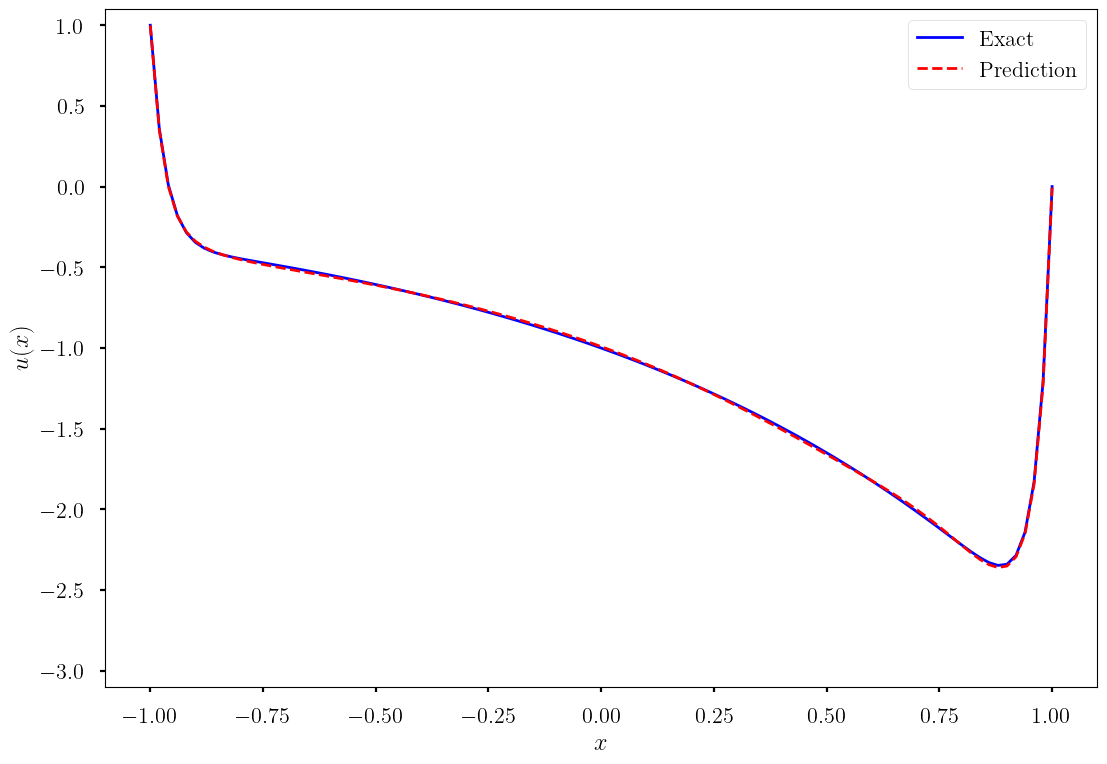

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


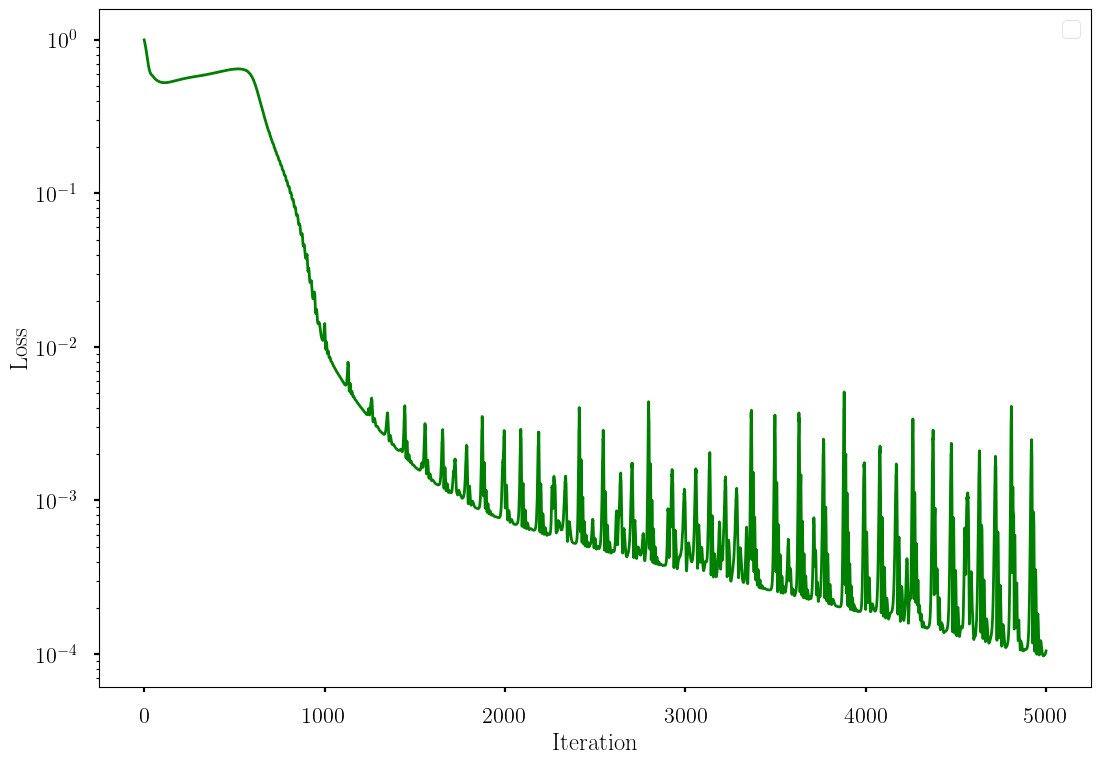

In [12]:
def predict(X_star_tf, w, b):
    x_star = X_star_tf
    u_pred = net_u(x_star, w, b)
    return u_pred

u_star = y_act.reshape(-1, 1)
    
u_pred = predict(X_star_tf, W, b)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)


print(f"L_2 relative error is: {error_u*100} %")                     



####### Row 1: u(t,x) slices ##################    
gs1 = gridspec.GridSpec(1, 1)
#gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,y_act, 'b-', linewidth = 2, label = 'Exact')       
ax.plot(X_f_star, u_pred, '--r', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(x)$') 
plt.legend()
#ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-3.1,1.1])
plt.show()

###############################################
loss_list = [loss[i].numpy() for i in range(len(loss))]


gs2 = gridspec.GridSpec(1, 1)
ax = plt.subplot(gs2[0, 0])

ep = np.arange(0,Nmax+1,1)
ax.semilogy(ep,loss_list/(np.max(loss_list)), 'g-', linewidth = 2)       
ax.set_xlabel('Iteration')
ax.set_ylabel('Loss') 
plt.legend()
#ax.axis('square')
##ax.set_xlim([-1.1,1.1])
##x.set_ylim([-3.1,1.1])
plt.show()



## RBA FOR Allen-Cahn

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from pyDOE import lhs
import math
import time

pi = math.pi
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [14]:
### Initialize PINN Model
class PINN(nn.Module):
    def __init__(self, layers):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()

        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i + 1]))

        self.activation = nn.Tanh()

    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = self.activation(self.layers[i](x))
        x = self.layers[-1](x)
        return x

In [15]:
## Define data and Losses

def data_loss(model, x, t, u_true):
    u_pred = model(torch.cat([x, t], dim=1))
    return (u_pred - u_true).pow(2).mean()

def ac_loss(model, x, t, D):
    x.requires_grad = True
    t.requires_grad = True
    u = model(torch.cat([x, t], dim=1))
    u_t = torch.autograd.grad(u, t, torch.ones_like(u), create_graph=True)[0]
    u_x = torch.autograd.grad(u, x, torch.ones_like(u), create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x, x, torch.ones_like(u_x), create_graph=True)[0]
    f = u_t - D * u_xx + 5.0 * (u**3 - u)
    return f


In [18]:
# Initialize Model
layers = [2, 128, 128, 128, 128, 1]
model = PINN(layers).to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total params: {total_params}:")

Total params: 50049:


In [19]:
## Optimizer and Hyperparameters
optimizer = optim.Adam(model.parameters(), lr=5e-4)
D = 0.0001
N_i = 200
N_b = 100
N_f = 50000
lb = np.array([-1, 0])
ub = np.array([1, 1])
xt_f = lb + (ub - lb)*lhs(2, N_f)

In [20]:
##RBA Infra
lr_lambdas =0.01
gamma= 0.999
lambdas=torch.ones((N_f,1),requires_grad=True).to(device)

In [ ]:
#### Fill in Data for IC and BCs                                                                                                                      
x_ic = torch.linspace(-1, 1, steps=N_i).view(-1, 1).to(device)
t_ic = torch.zeros(N_i, 1).view(-1, 1).to(device)
u_ic = (x_ic**2 * torch.cos(pi*x_ic)).view(-1, 1).to(device)

x_lb = -1.0 * torch.ones(N_b, 1).view(-1, 1).to(device)
t_lb = torch.linspace(0, 1, steps=N_b).view(-1, 1).to(device)
u_lb = -1.0 * torch.ones(N_b, 1).view(-1, 1).to(device)

x_rb = 1.0 * torch.ones(N_b, 1).view(-1, 1).to(device)
t_rb = torch.linspace(0, 1, steps=N_b).view(-1, 1).to(device)
u_rb = -1.0 * torch.ones(N_b, 1).to(device)

x_f = torch.tensor(xt_f[:, 0], dtype=torch.float32).view(-1, 1).to(device)
t_f = torch.tensor(xt_f[:, 1], dtype=torch.float32).view(-1, 1).to(device)
loss_list = []
num_epochs = 150001

t1=time.time()
for epoch in range(num_epochs):
    optimizer.zero_grad()
    f_i = ac_loss(model, x_f, t_f, D)
    new_lambdas = gamma * lambdas + lr_lambdas * f_i / torch.max(lambdas.detach()+0.00000001)
    lambdas = new_lambdas.detach().requires_grad_()
    f_i = ac_loss(model, x_f, t_f, D)
    f_loss = torch.mean((lambdas*f_i)**2)
    l_b_loss = data_loss(model, x_lb, t_lb, u_lb)
    r_b_loss = data_loss(model, x_rb, t_rb, u_rb)
    i_c_loss = data_loss(model, x_ic, t_ic, u_ic)
    loss = f_loss + l_b_loss + r_b_loss + i_c_loss
    loss.backward()
    optimizer.step()
    t2 = time.time()
    loss_list.append(loss.item())
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}, f_loss: {f_loss.item()}, total_loss: {loss.item()}, time: {t2-t1} sec')

t3 = time.time()

print(f"Elapsed Time: {t3-t1} sec")

Epoch 0, Loss: 1.9942703247070312, f_loss: 0.2051897644996643, total_loss: 1.9942703247070312, time: 3.6408541202545166 sec


## Trick 1: Minmax for Optimizer for RBA

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim

class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.layer1 = nn.Linear(2, 2) 
        self.layer2 = nn.Linear(2, 2)  

    def forward(self, x):
        x = self.layer1(x)
        x = torch.tanh(x)
        x = self.layer2(x)
        return x

def loss_function(output, target):
    return torch.sum((output - target) ** 2)


In [25]:
model = NN()
optimizer = optim.SGD(model.parameters(), lr=0.1)
input_data = torch.tensor([[1.0, 2.0]])
target = torch.tensor([0.0, 0.0])

In [29]:
output = model(input_data)
loss = loss_function(output, target)
loss.backward()

In [37]:
# Original parameters
for p in model.layer2.parameters():
    print("Parameters grad before negation: ", p.grad)
    
# Apply negation
for p in model.layer2.parameters():
    p.grad *= -1

# After negation
for p in model.layer2.parameters():
    print("Parameters after modeification: ", p.grad)
    p.grad *= -1

Parameters grad before negation:  tensor([[ 0.1875,  1.4163],
        [-0.0131, -0.0992]])
Parameters grad before negation:  tensor([-1.5700,  0.1099])
Parameters after modeification:  tensor([[-0.1875, -1.4163],
        [ 0.0131,  0.0992]])
Parameters after modeification:  tensor([ 1.5700, -0.1099])


In [40]:
help(model.layer2.parameters)

Help on method parameters in module torch.nn.modules.module:

parameters(recurse: bool = True) -> Iterator[torch.nn.parameter.Parameter] method of torch.nn.modules.linear.Linear instance
    Return an iterator over module parameters.
    
    This is typically passed to an optimizer.
    
    Args:
        recurse (bool): if True, then yields parameters of this module
            and all submodules. Otherwise, yields only parameters that
            are direct members of this module.
    
    Yields:
        Parameter: module parameter
    
    Example::
    
        >>> # xdoctest: +SKIP("undefined vars")
        >>> for param in model.parameters():
        >>>     print(type(param), param.size())
        <class 'torch.Tensor'> (20L,)
        <class 'torch.Tensor'> (20L, 1L, 5L, 5L)

